In [646]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import MinMaxScaler

In [647]:
# Iterate through existing models and load them in
PATH= "models"
ext=".joblib"
models = {}
stocks = []
for model in os.listdir(PATH):
    file_path = os.path.join(PATH, model)
    
    # Check if it's a proper model
    if os.path.isfile(file_path) and os.path.splitext(file_path)[1] == ext:
        stock = os.path.splitext(file_path)[0].split("/")[1]
        stocks.append(stock)
        models[stock] = joblib.load(file_path)

In [648]:
list(models.values())

In [649]:
stocks

['TROW',
 'QRVO',
 'EQIX',
 'MDT',
 'DVN',
 'TER',
 'TPR',
 'GILD',
 'NVR',
 'CSCO',
 'CE',
 'VRTX',
 'ISRG',
 'UAL',
 'V',
 'BA',
 'MRO']

In [650]:
start_date = '2000-01-01'
end_date = '2021-12-31'

In [651]:
features = ["Adj Close", "ATR", "RSI", "Volume", "Adj Close_lag1", "Adj Close_lag2"]
def generate_data(df, start_date, end_date):
    df["Adj Close_lag1"]=df["Adj Close"].shift(1)    
    df["Adj Close_lag2"]=df["Adj Close"].shift(2)
    df = df[features]    
    df = df.dropna()
    df = df[start_date:end_date]
    return df

In [652]:
FILEPATH = "/Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/Data/individual_data/"
truth = {}
pred = {}
indices = None
assigned = False
for stock in stocks:
    stock_df = pd.read_csv(FILEPATH+f"{stock}.csv")    
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    stock_df.set_index('Date', inplace=True)
    test = generate_data(stock_df, start_date=start_date, end_date=end_date)    
    X_test = test.drop("Adj Close", axis=1)
    y_test = test["Adj Close"]    
    if not assigned:
        indices = y_test.index
        assigned = True
    trained_model = models[stock]
    y_pred = trained_model.predict(xgb.DMatrix(X_test))
    truth[stock] = y_test
    pred[stock] = y_pred
    print(stock_df.shape)


(2768, 11)
(1258, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)
(2768, 11)


In [653]:
indices

DatetimeIndex(['2009-01-06', '2009-01-07', '2009-01-08', '2009-01-09',
               '2009-01-12', '2009-01-13', '2009-01-14', '2009-01-15',
               '2009-01-16', '2009-01-20',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=2766, freq=None)

In [654]:
pred_df = pd.DataFrame({key: pd.Series(value) for key, value in pred.items()})
true_df = pd.DataFrame({key: pd.Series(value) for key, value in truth.items()})
pred_df.index=indices
true_df.index=indices
true_df_excluding_last_day = true_df.drop(index = indices[-1])
pred_df_excluding_first_day = pred_df.drop(index = indices[0])

In [655]:
def generate_portfolio_weights(truth, pred):
    index = pred.index
    cols = pred.columns
    truth_values = truth.values
    pred_values = pred.values
    sc = MinMaxScaler(feature_range = (0, 1))
    res = (pred_values - truth_values)/truth_values
    res = sc.fit_transform(res.T).T
    res_sums = np.sum(res, axis=1)[:, np.newaxis]    
    scaled_res = res/res_sums
    weights = pd.DataFrame(data=scaled_res, columns=cols, index=index)
    return weights
    

In [656]:
portfolio_weights = generate_portfolio_weights(true_df_excluding_last_day, pred_df_excluding_first_day)
portfolio_weights

,TROW,QRVO,EQIX,MDT,DVN,TER,TPR,GILD,NVR,CSCO,CE,VRTX,ISRG,UAL,V,BA,MRO
Date,,,,,,,,,,,,,,,,,
2009-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [657]:
true_df_excluding_first_day = true_df.iloc[1:]

In [658]:
portfolio_weights.to_csv("weights.csv")
true_df_excluding_first_day.to_csv("truth.csv")

In [659]:
returns_data = true_df.pct_change().iloc[1:, :] 
## normalize weights to (0, 1)
sc = MinMaxScaler(feature_range = (0, 1))
weights_data = pd.DataFrame(sc.fit_transform(returns_data.T).T, index = portfolio_weights.index, columns=true_df.columns)

In [660]:
## Sum weights to 1
weights_data['total'] = weights_data.sum(axis=1)
for col in weights_data.columns:
    weights_data[col] = weights_data[col]/weights_data['total']
weights_data = weights_data.drop(columns=['total'])
# weights_array = weights_data.values

weights_data

,TROW,QRVO,EQIX,MDT,DVN,TER,TPR,GILD,NVR,CSCO,CE,VRTX,ISRG,UAL,V,BA,MRO
Date,,,,,,,,,,,,,,,,,
2009-01-07,0.012323,NaN,0.000000,0.110122,0.041513,0.062371,0.072226,0.069400,0.069938,0.059725,0.113195,0.087182,0.049130,0.091344,0.065376,0.051287,0.044867
2009-01-08,0.054662,NaN,0.075649,0.071184,0.045576,0.093364,0.028878,0.059612,0.079502,0.068391,0.055546,0.064039,0.000000,0.110511,0.047092,0.057415,0.088579
2009-01-09,0.043202,NaN,0.070050,0.090637,0.073919,0.059624,0.000000,0.069684,0.068372,0.053748,0.104631,0.047057,0.034173,0.057758,0.082241,0.079051,0.065853
2009-01-12,0.063185,NaN,0.054404,0.095942,0.058994,0.061685,0.047628,0.097252,0.034347,0.079991,0.000000,0.085492,0.088536,0.046212,0.046635,0.082215,0.057481
2009-01-13,0.066935,NaN,0.070394,0.056132,0.076164,0.064607,0.051163,0.073230,0.070036,0.059400,0.042711,0.118231,0.076349,0.000000,0.059775,0.024760,0.090115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.076095,0.092581,0.067881,0.051815,0.105492,0.051379,0.002334,0.054335,0.089729,0.028467,0.062301,0.067203,0.065911,0.042688,0.067131,0.000000,0.074659
2019-12-26,0.081342,0.034218,0.111460,0.019373,0.013621,0.102289,0.152245,0.023759,0.041522,0.059157,0.038539,0.043308,0.043969,0.057881,0.097872,0.000000,0.079445
2019-12-27,0.068664,0.050965,0.084933,0.089843,0.000000,0.049285,0.032286,0.050483,0.074317,0.064967,0.074839,0.079408,0.069071,0.040711,0.073406,0.071802,0.025020


In [661]:
def backtest(test_df, weights):
    '''
    df of stocks with index being date, cols being stocks, each entry being the price 
    weights represent the normalized portfolio weights, a matrix of dimension (n_days, n_stocks)
    '''
    returns = test_df.pct_change().dropna()
    # zeros_row = pd.DataFrame(np.zeros((1, 10)), columns=returns.columns)
    # returns = pd.concat([zeros_row, returns])

    portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    print(cumulative_returns)
    annualized_return = (cumulative_returns[-1])**(252/len(cumulative_returns.index)) - 1  # Assuming 252 trading days
    annualized_volatility = np.std(portfolio_returns, axis=0) * np.sqrt(252)

    # Calculate Sharpe Ratio
    risk_free_rate = 0.03 # can change 
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate Maximum Drawdown
    cumulative_returns_index = (1 + portfolio_returns).cumprod()
    cumulative_max = cumulative_returns_index.cummax()
    drawdown = (cumulative_returns_index - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns)
    plt.title('Portfolio Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()


Date
2009-01-07        1.000000
2009-01-08        1.000000
2009-01-09        1.000000
2009-01-12        1.000000
2009-01-13        1.000000
                  ...     
2019-12-24    38981.509981
2019-12-26    39219.206110
2019-12-27    39192.540148
2019-12-30    38992.593810
2019-12-31    39254.628503
Length: 2765, dtype: float64
Annualized Return: 162.23%
Annualized Volatility: 16.31%
Sharpe Ratio: 9.76
Maximum Drawdown: -9.54%


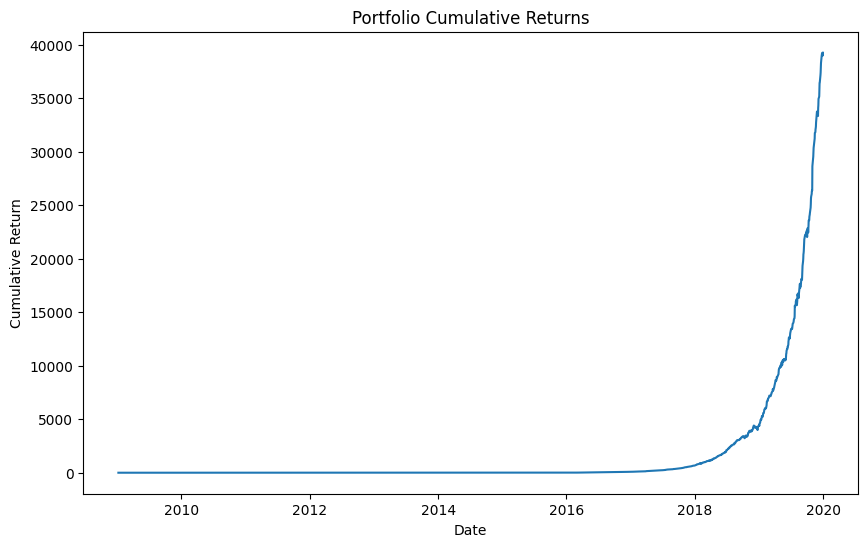

In [662]:
backtest(true_df_excluding_first_day, weights_data)

Date
2009-01-07    1.0
2009-01-08    1.0
2009-01-09    1.0
2009-01-12    1.0
2009-01-13    1.0
             ... 
2019-12-24    1.0
2019-12-26    1.0
2019-12-27    1.0
2019-12-30    1.0
2019-12-31    1.0
Length: 2765, dtype: float64
Annualized Return: 0.00%
Annualized Volatility: 0.00%
Sharpe Ratio: -inf
Maximum Drawdown: 0.00%


/var/folders/dh/77csj5hj70b305yqt5ym43vh0000gn/T/ipykernel_20280/2480789139.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility


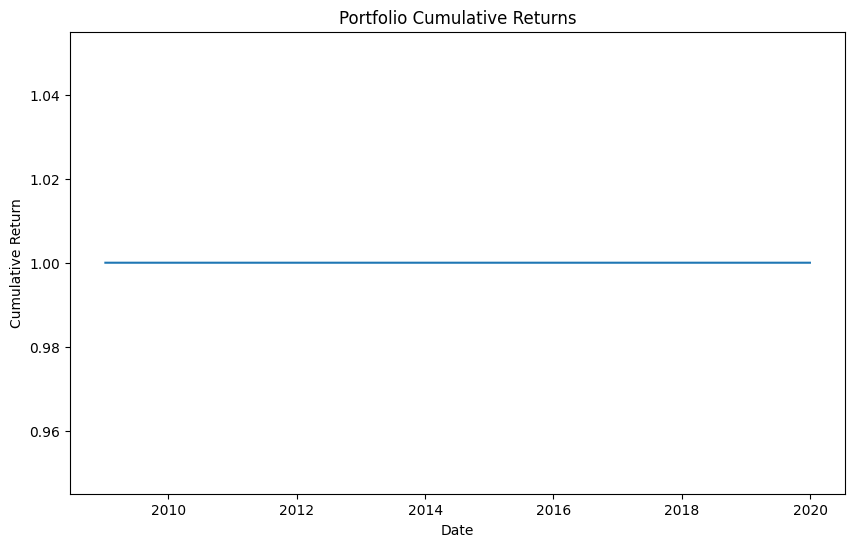

In [663]:
backtest(true_df_excluding_first_day, portfolio_weights)